In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


In [2]:
df = pd.read_excel('Project2Data.xls')
df.isnull().sum()
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 0 to 84
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Area                83 non-null     object        
 1   Date                83 non-null     datetime64[ns]
 2   PaperContaminant    83 non-null     float64       
 3   PlasticContaminant  83 non-null     float64       
 4   CanContaminant      83 non-null     float64       
 5   FirstTrialPhase     83 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 4.5+ KB


In [64]:
# standardize column names
df.columns = df.columns.str.strip()

# convert Phase to categorical variable
df['FirstTrialPhase'] = df['FirstTrialPhase'].astype('category')
# confirm unique values
print(df['Area'].unique())
print(df['FirstTrialPhase'].unique())

# create treatment group indicator
df['UTOWN'] = (df['Area'] == 'UTOWN').astype(int)

['ENGINE' 'UTOWN']
[1.0, 2.0, 3.0]
Categories (3, float64): [1.0, 2.0, 3.0]


In [65]:
summary = df.groupby(['Area', 'FirstTrialPhase'])[['PaperContaminant', 'PlasticContaminant', 'CanContaminant']].mean().round(2)
print(summary)

                        PaperContaminant  PlasticContaminant  CanContaminant
Area   FirstTrialPhase                                                      
ENGINE 1.0                          0.85               48.35           14.85
       2.0                          1.29               35.96           11.67
       3.0                          0.75               40.88            7.55
UTOWN  1.0                          6.36               60.30           36.47
       2.0                          4.00               46.51           18.34
       3.0                          4.69               59.18           22.31


/var/folders/_x/lsrbq0ts05zbxx2p0w54wjx40000gn/T/ipykernel_41122/518131768.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['Area', 'FirstTrialPhase'])[['PaperContaminant', 'PlasticContaminant', 'CanContaminant']].mean().round(2)


/var/folders/_x/lsrbq0ts05zbxx2p0w54wjx40000gn/T/ipykernel_41122/3812173940.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = subset.groupby('FirstTrialPhase')[var].mean()


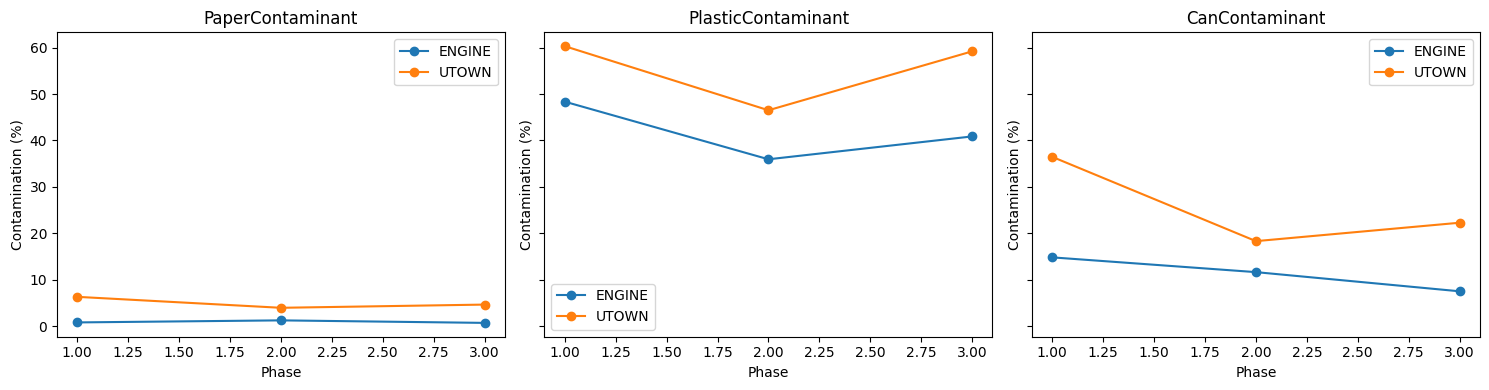

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, var in enumerate(['PaperContaminant', 'PlasticContaminant', 'CanContaminant']):
    for area in df['Area'].unique():
        subset = df[df['Area'] == area]
        means = subset.groupby('FirstTrialPhase')[var].mean()
        axes[i].plot(means.index, means.values, marker='o', label=area)
    axes[i].set_title(var)
    axes[i].set_xlabel('Phase')
    axes[i].set_ylabel('Contamination (%)')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Baseline balance test (Phase 1 only)

In [69]:
for y in ["PaperContaminant","PlasticContaminant","CanContaminant"]:
    m = smf.ols(f"{y} ~ C(Area)", data=df[df["FirstTrialPhase"]==1]).fit(cov_type="HC3")
    print(f"\nBaseline balance ({y}):")
    print(m.summary().tables[1])



Baseline balance (PaperContaminant):
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8531      0.095      9.014      0.000       0.668       1.039
C(Area)[T.UTOWN]     5.5036      0.844      6.524      0.000       3.850       7.157

Baseline balance (PlasticContaminant):
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           48.3541      2.744     17.621      0.000      42.976      53.733
C(Area)[T.UTOWN]    11.9439      3.211      3.719      0.000       5.650      18.238

Baseline balance (CanContaminant):
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.8500      2.1

### primary DiD variables

In [70]:
# --- build primary DiD variables once ---
df['Area'] = df['Area'].str.upper().str.strip()
df['Treat'] = (df['Area'] == 'UTOWN').astype(int)
df['PhaseNum'] = df['FirstTrialPhase'].astype(str).str.extract(r'(\d+)').astype(float).astype('Int64')
df['Post'] = (df['PhaseNum'] >= 2).astype(int)

materials = ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']
results_2x2 = {}

for var in materials:
    formula = f'{var} ~ Treat + Post + Treat:Post'   # PRIMARY 2×2 DiD
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    results_2x2[var] = model

    did = model.params.get('Treat:Post', np.nan)
    se  = model.bse.get('Treat:Post', np.nan)
    pv  = model.pvalues.get('Treat:Post', np.nan)

    print(f"\n===== {var} (Primary 2×2 DiD) =====")
    print(model.summary().tables[1])           # coef table
    print(f"\nDID (Treat×Post): {did:.4f}  |  SE: {se:.4f}  |  p-value: {pv:.4f}")


===== PaperContaminant (Primary 2×2 DiD) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8531      0.092      9.282      0.000       0.673       1.033
Treat          5.5036      0.819      6.719      0.000       3.898       7.109
Post           0.1589      0.366      0.434      0.665      -0.559       0.877
Treat:Post    -2.1703      0.958     -2.265      0.023      -4.048      -0.292

DID (Treat×Post): -2.1703  |  SE: 0.9581  |  p-value: 0.0235

===== PlasticContaminant (Primary 2×2 DiD) =====
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.3541      2.665     18.146      0.000      43.131      53.577
Treat         11.9439      3.118      3.830      0.000       5.832      18.056
Post          -9.8307      3.276     -3.000      0

### 2×2 DiD (Phase 1 vs 2)

In [71]:
# ==== 2×2 DiD (Phase 1 vs 2) — print full summaries ====
df_2x2 = df[df['FirstTrialPhase'].isin([1.0, 2.0])].copy()

print("\n\n===== 2x2 DiD (Phase 1 vs 2) =====")
for var in ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']:
    print(f"\n--- Outcome: {var} ---")
    formula = f'{var} ~ C(Area) * C(FirstTrialPhase)'
    model_2x2 = smf.ols(formula, data=df_2x2).fit(
        cov_type="cluster", cov_kwds={"groups": df_2x2["Date"]}
    )
    print(model_2x2.summary())





===== 2x2 DiD (Phase 1 vs 2) =====

--- Outcome: PaperContaminant ---
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     28.51
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           4.80e-09
Time:                        16:04:02   Log-Likelihood:                -132.83
No. Observations:                  60   AIC:                             273.7
Df Residuals:                      56   BIC:                             282.0
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

/Users/tanganan/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tanganan/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/tanganan/Library/Python/3.9/lib/python/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/tanganan/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/tanganan/Library/Python/3.9/lib/python/site-pac

### 2×2 DiD (Phase 1 vs 3)

In [3]:
# ==== 2×2 DiD (Phase 1 vs 3) — print full summaries ====
import pandas as pd
import statsmodels.formula.api as smf

# keep only phases 1 and 3
df_2x2_13 = df[df['FirstTrialPhase'].isin([1.0, 3.0])].copy()

# (robustness) types & ordering so baselines are clear
df_2x2_13['Date'] = pd.to_datetime(df_2x2_13['Date'])
df_2x2_13['Area'] = pd.Categorical(df_2x2_13['Area'], categories=['ENGINE', 'UTOWN'])
df_2x2_13['FirstTrialPhase'] = pd.Categorical(
    df_2x2_13['FirstTrialPhase'], ordered=True, categories=[1.0, 3.0]
)

print("\n\n===== 2x2 DiD (Phase 1 vs 3) =====")
for var in ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']:
    print(f"\n--- Outcome: {var} ---")
    # Explicitly set references so the DiD term is UTOWN × Phase3 vs ENGINE × Phase1
    formula = (f'{var} ~ '
               'C(Area, Treatment(reference="ENGINE"))'
               '* C(FirstTrialPhase, Treatment(reference=1.0))')
    model_2x2_13 = smf.ols(formula, data=df_2x2_13).fit(
        cov_type="cluster", cov_kwds={"groups": df_2x2_13["Date"]}
    )
    print(model_2x2_13.summary())



===== 2x2 DiD (Phase 1 vs 3) =====

--- Outcome: PaperContaminant ---
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     47.29
Date:                Sat, 18 Oct 2025   Prob (F-statistic):           7.29e-12
Time:                        23:37:03   Log-Likelihood:                -133.22
No. Observations:                  61   AIC:                             274.4
Df Residuals:                      57   BIC:                             282.9
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                                                                                          coef    std err          z      

### 2×2 DiD (Phase 2 vs 3)

In [74]:
# --- DiD Analysis: Comparing Phase 3 vs. Phase 2---
df_p2_vs_p3 = df[df['FirstTrialPhase'].isin([2.0, 3.0])].copy()
df_p2_vs_p3['FirstTrialPhase'] = df_p2_vs_p3['FirstTrialPhase'].cat.remove_unused_categories()
print("--- DiD Analysis: Comparing Phase 3 vs. Phase 2 ---")
print("--- Phase 2 is treated as the 'pre-intervention' period ---\n")

for var in ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']:
    print(f"--- Outcome: {var} ---")
    
    # Define the DiD formula with Phase 2 as the explicit reference.
    # Now, the model will only see categories 2.0 and 3.0.
    formula = f'{var} ~ C(Area) * C(FirstTrialPhase, Treatment(reference=2.0))'
    
    model = smf.ols(formula, data=df_p2_vs_p3).fit(
        cov_type="cluster", cov_kwds={"groups": df_p2_vs_p3["Date"]}
    )
    
    print(model.summary())
    print("\n" + "="*80 + "\n")

--- DiD Analysis: Comparing Phase 3 vs. Phase 2 ---
--- Phase 2 is treated as the 'pre-intervention' period ---

--- Outcome: PaperContaminant ---
                            OLS Regression Results                            
Dep. Variable:       PaperContaminant   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     40.80
Date:                Fri, 17 Oct 2025   Prob (F-statistic):           3.69e-09
Time:                        16:13:29   Log-Likelihood:                -84.931
No. Observations:                  45   AIC:                             177.9
Df Residuals:                      41   BIC:                             185.1
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                                               

### Dynamic DID （Event Phase）: Phase 2 vs 1 & Phase 3 vs 1

In [39]:
materials = ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']
results = {}

for var in materials:
    formula = f'{var} ~ C(Area)*C(FirstTrialPhase)'
    model = smf.ols(formula, data=df).fit(cov_type='HC1')
    results[var] = model
    print(f"\n===== {var} =====")
    print(model.summary().tables[1])


===== PaperContaminant =====
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      0.8531      0.093      9.164      0.000       0.671       1.036
C(Area)[T.UTOWN]                               5.5036      0.830      6.633      0.000       3.877       7.130
C(FirstTrialPhase)[T.2.0]                      0.4417      0.617      0.716      0.474      -0.767       1.651
C(FirstTrialPhase)[T.3.0]                     -0.1004      0.397     -0.253      0.801      -0.879       0.678
C(Area)[T.UTOWN]:C(FirstTrialPhase)[T.2.0]    -2.7984      1.120     -2.498      0.013      -4.994      -0.602
C(Area)[T.UTOWN]:C(FirstTrialPhase)[T.3.0]    -1.5657      1.056     -1.482      0.138      -3.636       0.505

===== PlasticContaminant =====
                                                 c

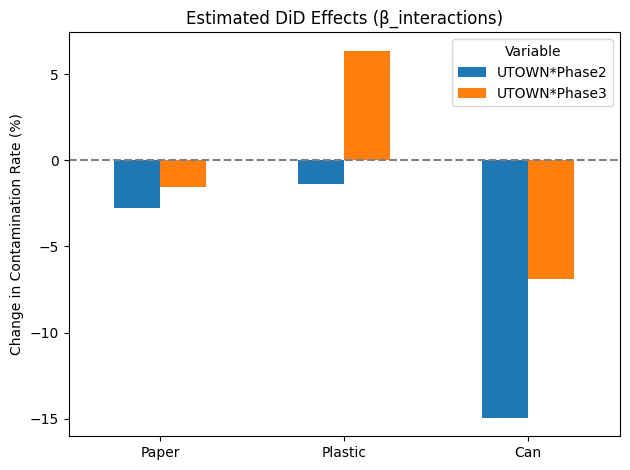

In [40]:
import matplotlib.pyplot as plt

# --- Corrected Code Starts Here ---

# Dynamically find the full names of the interaction terms
# We look for the parameter names that contain both 'Area' and 'FirstTrialPhase'
paper_interactions = [p for p in results['PaperContaminant'].params.index if 'C(Area)' in p and 'C(FirstTrialPhase)' in p]
plastic_interactions = [p for p in results['PlasticContaminant'].params.index if 'C(Area)' in p and 'C(FirstTrialPhase)' in p]
can_interactions = [p for p in results['CanContaminant'].params.index if 'C(Area)' in p and 'C(FirstTrialPhase)' in p]

# Sort them to ensure Phase 2 comes before Phase 3
paper_interactions.sort()
plastic_interactions.sort()
can_interactions.sort()


# Build the DataFrame using the dynamically found names
effects = pd.DataFrame({
    'Variable': ['UTOWN*Phase2', 'UTOWN*Phase3'],
    'Paper': [
        results['PaperContaminant'].params[paper_interactions[0]],
        results['PaperContaminant'].params[paper_interactions[1]]
    ],
    'Plastic': [
        results['PlasticContaminant'].params[plastic_interactions[0]],
        results['PlasticContaminant'].params[plastic_interactions[1]]
    ],
    'Can': [
        results['CanContaminant'].params[can_interactions[0]],
        results['CanContaminant'].params[can_interactions[1]]
    ]
})

# --- Plotting Code (unchanged) ---

effects.set_index('Variable').T.plot(kind='bar')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Estimated DiD Effects (β_interactions)')
plt.ylabel('Change in Contamination Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Mean difference between phase 2 vs 3 to test additional effect 

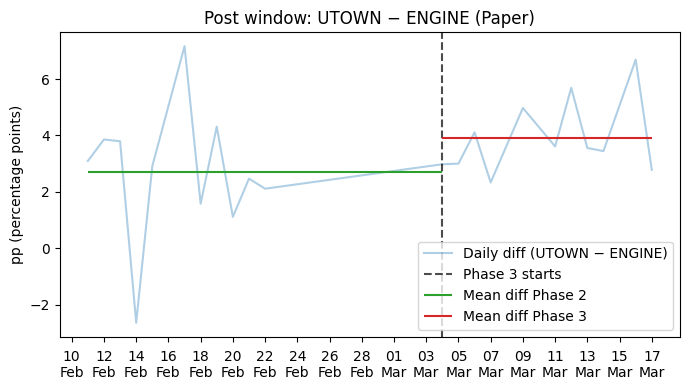

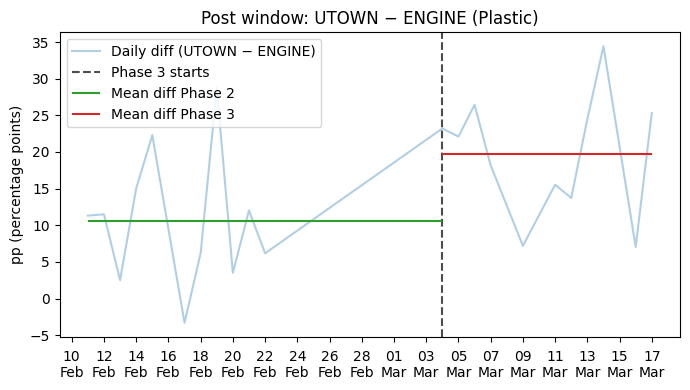

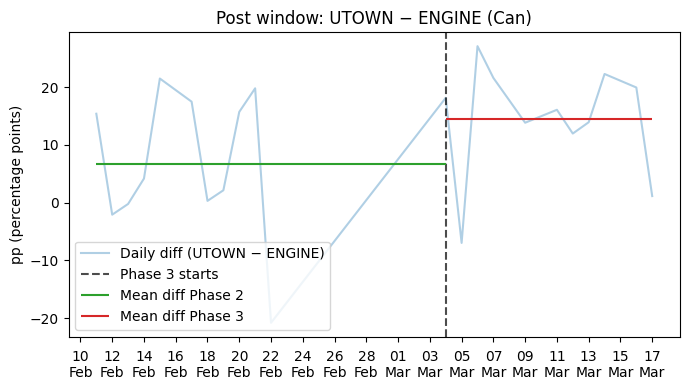

In [75]:
def plot_post_diff(df, var, title_label, show_daily=True):
    post = df[df['FirstTrialPhase'].isin([2.0, 3.0])].copy()

    # daily UTOWN and ENGINE means; keep only days where both exist
    pivot = (post.pivot_table(index='Date', columns='Area', values=var, aggfunc='mean')
                  .rename_axis(None, axis=1)
                  .dropna(subset=['ENGINE','UTOWN']))

    daily = (pivot.assign(diff=lambda d: d['UTOWN'] - d['ENGINE'])
                  .merge(post[['Date','FirstTrialPhase']].drop_duplicates(), left_index=True, right_on='Date')
                  .sort_values('Date'))

    phase3_start = daily.loc[daily['FirstTrialPhase']==3.0, 'Date'].min()
    mean2 = daily.loc[daily['FirstTrialPhase']==2.0, 'diff'].mean()
    mean3 = daily.loc[daily['FirstTrialPhase']==3.0, 'diff'].mean()

    fig, ax = plt.subplots(figsize=(7,4))

    if show_daily:
        ax.plot(daily['Date'], daily['diff'], alpha=0.35, label='Daily diff (UTOWN − ENGINE)')

    if pd.notnull(phase3_start):
        ax.axvline(phase3_start, color='k', linestyle='--', alpha=0.7, label='Phase 3 starts')

    ax.hlines(mean2, xmin=daily['Date'].min(), xmax=phase3_start, colors='tab:green', label='Mean diff Phase 2')
    ax.hlines(mean3, xmin=phase3_start, xmax=daily['Date'].max(), colors='tab:red', label='Mean diff Phase 3')

    ax.set_title(f'Post window: UTOWN − ENGINE ({title_label})')
    ax.set_ylabel('pp (percentage points)')

    # Clean 2-line day/month ticks
    locator   = mdates.DayLocator(interval=2)     # tweak interval as you like
    formatter = mdates.DateFormatter('%d\n%b')    # day on top, month below
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=0, pad=6)

    ax.legend()
    plt.tight_layout()
    plt.show()

# three separate plots (recommended)
plot_post_diff(df, 'PaperContaminant',   'Paper',   show_daily=True)
plot_post_diff(df, 'PlasticContaminant', 'Plastic', show_daily=True)
plot_post_diff(df, 'CanContaminant',     'Can',     show_daily=True)





### ANOVA 

In [41]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [42]:
df = df.copy()
df['Area'] = df['Area'].astype('category')                   # {'ENGINE','UTOWN'}
df['FirstTrialPhase'] = df['FirstTrialPhase'].astype('category')  # {1,2,3}
materials = ['PaperContaminant','PlasticContaminant','CanContaminant']


In [43]:
def fmt_p(p): return "<0.001" if p < 0.001 else f"{p:.3f}"

def add_partial_eta2(aov):
    aov = aov.copy()
    ss_err = aov.loc['Residual','sum_sq']
    for idx in aov.index:
        if idx != 'Residual':
            aov.loc[idx,'partial_eta2'] = aov.loc[idx,'sum_sq'] / (aov.loc[idx,'sum_sq'] + ss_err)
    return aov

def pretty_anova(aov):
    a = aov.copy()
    a['sum_sq'] = a['sum_sq'].map(lambda x: f"{x:.3f}")
    a['df'] = a['df'].map(lambda x: f"{x:.0f}")
    if 'F' in a: a['F'] = a['F'].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")
    a['PR(>F)'] = a['PR(>F)'].map(lambda x: "" if pd.isna(x) else fmt_p(x))
    if 'partial_eta2' in a: a['partial_eta2'] = a['partial_eta2'].map(lambda x: f"{x:.3f}")
    return a


In [44]:
def run_anova(df, y):
    print(f"\n=== {y}: Area × Phase (Type III) ===")
    model = ols(f"{y} ~ C(Area, Sum) * C(FirstTrialPhase, Sum)", data=df).fit()
    aov = anova_lm(model, typ=3)
    aov = add_partial_eta2(aov)
    print(pretty_anova(aov).to_string())
    # Assumptions (concise, 3 dp)
    groups = [df.loc[(df['Area']==a)&(df['FirstTrialPhase']==p), y].dropna().values
              for a in df['Area'].cat.categories
              for p in df['FirstTrialPhase'].cat.categories]
    lev_stat, lev_p = stats.levene(*groups, center='median')
    sh_w, sh_p = stats.shapiro(model.resid)
    print(f"Levene: stat={lev_stat:.3f}, p={fmt_p(lev_p)}   Shapiro: W={sh_w:.3f}, p={fmt_p(sh_p)}")
    return {'model': model, 'anova': aov}


In [45]:
anova_results = {y: run_anova(df, y) for y in materials}

rows = []
for y, res in anova_results.items():
    a = res['anova']
    for term in ['C(Area, Sum)','C(FirstTrialPhase, Sum)','C(Area, Sum):C(FirstTrialPhase, Sum)']:
        if term in a.index:
            rows.append({
                'Outcome': y.replace('Contaminant',''),
                'Effect': term.replace('C(Area, Sum)','Area').replace('C(FirstTrialPhase, Sum)','Phase').replace(':','×'),
                'df': f"{a.loc[term,'df']:.0f}",
                'F': f"{a.loc[term,'F']:.3f}",
                'p': fmt_p(a.loc[term,'PR(>F)']),
                'partial_eta2': f"{a.loc[term,'partial_eta2']:.3f}"
            })
summary = pd.DataFrame(rows)[['Outcome','Effect','df','F','p','partial_eta2']]
print("\n--- Compact ANOVA Summary (3 dp) ---")
print(summary.to_string(index=False))



=== PaperContaminant: Area × Phase (Type III) ===
                                       sum_sq  df        F  PR(>F) partial_eta2
Intercept                             698.282   1  155.676  <0.001        0.669
C(Area, Sum)                          319.822   1   71.302  <0.001        0.481
C(FirstTrialPhase, Sum)                17.476   2    1.948   0.150        0.048
C(Area, Sum):C(FirstTrialPhase, Sum)   28.487   2    3.175   0.047        0.076
Residual                              345.382  77                           nan
Levene: stat=6.423, p=<0.001   Shapiro: W=0.865, p=<0.001

=== PlasticContaminant: Area × Phase (Type III) ===
                                          sum_sq  df         F  PR(>F) partial_eta2
Intercept                             183781.276   1  2491.831  <0.001        0.970
C(Area, Sum)                            3608.447   1    48.926  <0.001        0.389
C(FirstTrialPhase, Sum)                 2392.893   2    16.222  <0.001        0.296
C(Area, Sum):C(FirstTr

In [46]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# --- helpers (3-digit formatting) ---
p3 = lambda p: "<0.001" if p < 0.001 else f"{p:.3f}"

def full_anova_table(df, y):
    # Fit with sum-to-zero contrasts so Type III SS is meaningful term-by-term
    model = ols(f"{y} ~ C(Area, Sum) * C(FirstTrialPhase, Sum)", data=df).fit()
    aov3  = anova_lm(model, typ=3)

    # Pull per-term rows (variables): drop Intercept & Residual
    var_rows = aov3.drop(index=['Intercept','Residual'])
    # Overall Regression = sum of all model terms (excluding intercept)
    SSR    = var_rows['sum_sq'].sum()
    df_reg = int(var_rows['df'].sum())
    MSR    = SSR / df_reg if df_reg > 0 else np.nan
    F_over = float(model.fvalue) if model.fvalue is not None else np.nan
    p_over = float(model.f_pvalue) if model.f_pvalue is not None else np.nan

    # Residual & Total
    SSE    = float(aov3.loc['Residual','sum_sq'])
    df_res = int(aov3.loc['Residual','df'])
    MSE    = SSE / df_res
    SST    = SSR + SSE
    df_tot = df_reg + df_res

    # Build table in desired order: Regression, variables..., Residual, Total
    rows = []
    rows.append(["Regression", f"{df_reg:d}", f"{SSR:.3f}", f"{MSR:.3f}", f"{F_over:.3f}", p3(p_over)])

    # Variables = each model term with its own SS/df/MS/F/p
    rename = {
        'C(Area, Sum)': 'Area',
        'C(FirstTrialPhase, Sum)': 'Phase',
        'C(Area, Sum):C(FirstTrialPhase, Sum)': 'Area×Phase'
    }
    for term, r in var_rows.iterrows():
        name = rename.get(term, term)
        df_t = int(r['df'])
        ss_t = float(r['sum_sq'])
        ms_t = ss_t/df_t
        F_t  = "" if pd.isna(r['F']) else f"{r['F']:.3f}"
        p_t  = "" if pd.isna(r['PR(>F)']) else p3(float(r['PR(>F)']))
        rows.append([name, f"{df_t:d}", f"{ss_t:.3f}", f"{ms_t:.3f}", F_t, p_t])

    rows.append(["Residual", f"{df_res:d}", f"{SSE:.3f}", f"{MSE:.3f}", "", ""])
    rows.append(["Total",    f"{df_tot:d}", f"{SST:.3f}", "",            "", ""])

    tbl = pd.DataFrame(rows, columns=["Source","DF","Adj SS","Adj MS","F-Value","P-Value"])
    return model, tbl

# -------- run for each outcome and print ----------
materials = ["PaperContaminant","PlasticContaminant","CanContaminant"]
for y in materials:
    _, table = full_anova_table(df, y)
    print(f"\n=== ANOVA Table ({y.replace('Contaminant','')}) ===")
    print(table.to_string(index=False))



=== ANOVA Table (Paper) ===
    Source DF  Adj SS  Adj MS F-Value P-Value
Regression  5 365.785  73.157  19.446  <0.001
      Area  1 319.822 319.822  71.302  <0.001
     Phase  2  17.476   8.738   1.948   0.150
Area×Phase  2  28.487  14.243   3.175   0.047
  Residual 77 345.382   4.485                
     Total 82 711.167                        

=== ANOVA Table (Plastic) ===
    Source DF    Adj SS   Adj MS F-Value P-Value
Regression  5  6204.259 1240.852  17.029  <0.001
      Area  1  3608.447 3608.447  48.926  <0.001
     Phase  2  2392.893 1196.446  16.222  <0.001
Area×Phase  2   202.919  101.459   1.376   0.259
  Residual 77  5679.020   73.754                
     Total 82 11883.279                         

=== ANOVA Table (Can) ===
    Source DF    Adj SS   Adj MS F-Value P-Value
Regression  5  7160.322 1432.064  20.284  <0.001
      Area  1  4017.439 4017.439  48.691  <0.001
     Phase  2  2355.719 1177.860  14.275  <0.001
Area×Phase  2   787.165  393.582   4.770   0.011
  R

In [47]:
from statsmodels.formula.api import ols
materials = ["PaperContaminant","PlasticContaminant","CanContaminant"]

# Use treatment coding for readable coefficient names
models = {
    y: ols(f"{y} ~ C(Area) * C(FirstTrialPhase)", data=df).fit(cov_type="HC3")
    for y in materials
}


In [48]:
import pandas as pd
def p3(p): return "<0.001" if p < 0.001 else f"{p:.3f}"

def coef_table(m, digits=3):
    ci = m.conf_int(alpha=0.05)  # robust CI because cov_type="HC3"
    out = pd.DataFrame({
        "Term": m.params.index,
        "Coef": [f"{v:.{digits}f}" for v in m.params.values],
        "SE(HC3)": [f"{v:.{digits}f}" for v in m.bse.values],
        "t": [f"{v:.{digits}f}" for v in m.tvalues.values],
        "p": [p3(v) for v in m.pvalues.values],
        "CI Low": [f"{v:.{digits}f}" for v in ci[0].values],
        "CI High":[f"{v:.{digits}f}" for v in ci[1].values],
    })
    return out

for y, m in models.items():
    print(f"\n=== Partial Coefficient Tests (HC3) — {y.replace('Contaminant','')} ===")
    print(coef_table(m).to_string(index=False))



=== Partial Coefficient Tests (HC3) — Paper ===
                                      Term   Coef SE(HC3)      t      p CI Low CI High
                                 Intercept  0.853   0.095  9.014 <0.001  0.668   1.039
                          C(Area)[T.UTOWN]  5.504   0.844  6.524 <0.001  3.850   7.157
                 C(FirstTrialPhase)[T.2.0]  0.442   0.653  0.676  0.499 -0.838   1.721
                 C(FirstTrialPhase)[T.3.0] -0.100   0.417 -0.241  0.810 -0.917   0.717
C(Area)[T.UTOWN]:C(FirstTrialPhase)[T.2.0] -2.798   1.161 -2.410  0.016 -5.074  -0.523
C(Area)[T.UTOWN]:C(FirstTrialPhase)[T.3.0] -1.566   1.090 -1.436  0.151 -3.703   0.571

=== Partial Coefficient Tests (HC3) — Plastic ===
                                      Term    Coef SE(HC3)      t      p  CI Low CI High
                                 Intercept  48.354   2.744 17.621 <0.001  42.976  53.733
                          C(Area)[T.UTOWN]  11.944   3.211  3.719 <0.001   5.650  18.238
                 C(First

### Placebo Test

In [80]:
df['Date'] = pd.to_datetime(df['Date'])
df_phase1 = df[df['FirstTrialPhase'] == 1].copy()
df_phase1['UTOWN'] = (df_phase1['Area'] == 'UTOWN').astype(int)
median_date = df_phase1['Date'].median()
df_phase1['Placebo_Post'] = (df_phase1['Date'] > median_date).astype(int)

print(f"Phase 1 data has been split by the median date: {median_date.date()}")
print("Running DiD analysis on the two halves of Phase 1 to test for pre-trends...\n")

# Run the DiD model for each outcome variable
outcome_variables = ['PaperContaminant', 'PlasticContaminant', 'CanContaminant']

for outcome in outcome_variables:
    print(f"--- Placebo Test Results for: {outcome} ---")
    
    formula = f'{outcome} ~ UTOWN + Placebo_Post + UTOWN:Placebo_Post'
    
    # Fit the OLS model with HC3 robust standard errors
    model = smf.ols(formula, data=df_phase1).fit(cov_type='HC3')
    
    interaction_term = 'UTOWN:Placebo_Post'
    coef = model.params.get(interaction_term, np.nan)
    p_value = model.pvalues.get(interaction_term, np.nan)
    conf_int = model.conf_int().loc[interaction_term] if interaction_term in model.params else [np.nan, np.nan]
    
    # Print the regression coefficient table
    print(model.summary().tables[1])
    print("\n--- Interpretation ---")
    print(f"The placebo DiD effect (interaction term '{interaction_term}') is: {coef:.4f}")
    print(f"The p-value for this effect is: {p_value:.4f}")
    print(f"The 95% confidence interval is: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")

    # Provide a clear conclusion
    if p_value >= 0.05:
        print("Conclusion: The effect is NOT statistically significant (p >= 0.1).")
        print("This is the desired outcome. It suggests no pre-existing differential trend within Phase 1, which supports the parallel trends assumption.\n")
    else:
        print("Conclusion: The effect IS statistically significant (p < 0.1).")
        print("This is a WARNING sign. It suggests a potential violation of the parallel trends assumption.\n")
    print("="*70 + "\n")

Phase 1 data has been split by the median date: 2020-01-26
Running DiD analysis on the two halves of Phase 1 to test for pre-trends...

--- Placebo Test Results for: PaperContaminant ---
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.9524      0.147      6.468      0.000       0.664       1.241
UTOWN                  5.5921      1.094      5.113      0.000       3.448       7.736
Placebo_Post          -0.1886      0.196     -0.963      0.335      -0.572       0.195
UTOWN:Placebo_Post    -0.2077      1.809     -0.115      0.909      -3.753       3.337

--- Interpretation ---
The placebo DiD effect (interaction term 'UTOWN:Placebo_Post') is: -0.2077
The p-value for this effect is: 0.9086
The 95% confidence interval is: [-3.7528, 3.3374]
Conclusion: The effect is NOT statistically significant (p >= 0.1).
This is the desired outcome. It sug

### Global helper functions for robustness test

In [49]:
# ===================== Globals & Helpers (run once after Restart) =====================
import re, numpy as np, pandas as pd, statsmodels.api as sm, statsmodels.formula.api as smf

# Ensure Date is datetime
if not np.issubdtype(pd.Series(df['Date']).dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'])

CONT_COLS = ['PaperContaminant','PlasticContaminant','CanContaminant']

def scale_to_pp(df, cols):
    """
    For each column, if values look like fractions (0–1), scale to percentage points (×100).
    Uses the 99th percentile heuristic and never rescales if it's already in 0–100.
    """
    for c in cols:
        s = pd.to_numeric(df[c], errors='coerce')
        q99 = s.dropna().quantile(0.99)  # <- FIX: quantile on numeric series
        # Heuristic: if upper mass <= 1.05 -> treat as 0–1 fraction
        if pd.notna(q99) and q99 <= 1.05:
            df[c] = s * 100.0
        else:
            # keep as-is (already pp or has occasional outliers)
            df[c] = s
    return df

df = scale_to_pp(df, CONT_COLS)

def pick_iterm(model, post_level:int, area_label='UTOWN'):
    patterns = [
        rf'C\(Area.*?\)\[T\.{area_label}\]:C\(FirstTrialPhase.*?\)\[T\.{post_level}(?:\.0)?\]',
        rf'C\(FirstTrialPhase.*?\)\[T\.{post_level}(?:\.0)?\]:C\(Area.*?\)\[T\.{area_label}\]'
    ]
    for pat in patterns:
        for t in model.params.index:
            if re.fullmatch(pat, t):
                return t
    cands = [t for t in model.params.index
             if 'C(Area' in t and 'C(FirstTrialPhase' in t and f'T.{post_level}' in t]
    if cands:
        return cands[0]
    print("[WARN] Terms:", list(model.params.index))
    raise ValueError(f"Could not match Area×Phase interaction for level {post_level}")

def fit_cluster(formula, data, group_col='Date'):
    return smf.ols(formula, data=data).fit(cov_type='cluster', cov_kwds={'groups': data[group_col]})

def fit_hc3(formula, data):
    return smf.ols(formula, data=data).fit(cov_type='HC3')
# ===================== end Globals & Helpers =====================



### Make sure no difference betwen Plain vs HC3 vs Cluster-Date

In [55]:
def compare_se_specs(df, var, phases, label):
    dsub = df[df['FirstTrialPhase'].isin(phases)].copy()
    formula = f'{var} ~ C(Area) * C(FirstTrialPhase)'
    m_plain = smf.ols(formula, data=dsub).fit()
    m_hc3   = smf.ols(formula, data=dsub).fit(cov_type="HC3")
    m_cl    = smf.ols(formula, data=dsub).fit(cov_type='cluster', cov_kwds={'groups': dsub['Date']})
    # pick correct interaction
    iterm = pick_iterm(m_plain, post_level=int(phases[1]))
    def line(tag, m):
        lo, hi = m.conf_int().loc[iterm]
        print(f"  {tag:12s}  coef={m.params[iterm]:.3f}  CI=[{lo:.3f},{hi:.3f}]  p={m.pvalues[iterm]:.3f}")
    print(f"\n[{label}] {var}")
    line('Plain', m_plain); line('HC3', m_hc3); line('Cluster-Date', m_cl)

for phases, lbl in [([1.0,2.0],'1→2'),([1.0,3.0],'1→3'),([2.0,3.0],'2↔3 (post-only)')]:
    for v in ['PaperContaminant','PlasticContaminant','CanContaminant']:
        compare_se_specs(df, v, phases, lbl)




[1→2] PaperContaminant
  Plain         coef=-2.798  CI=[-5.258,-0.338]  p=0.027
  HC3           coef=-2.798  CI=[-5.074,-0.523]  p=0.016
  Cluster-Date  coef=-2.798  CI=[-5.005,-0.592]  p=0.013

[1→2] PlasticContaminant
  Plain         coef=-1.394  CI=[-11.217,8.428]  p=0.777
  HC3           coef=-1.394  CI=[-10.956,8.167]  p=0.775
  Cluster-Date  coef=-1.394  CI=[-10.087,7.298]  p=0.753

[1→2] CanContaminant
  Plain         coef=-14.957  CI=[-25.493,-4.420]  p=0.006
  HC3           coef=-14.957  CI=[-25.741,-4.172]  p=0.007
  Cluster-Date  coef=-14.957  CI=[-25.193,-4.721]  p=0.004

[1→3] PaperContaminant
  Plain         coef=-1.566  CI=[-3.919,0.788]  p=0.188
  HC3           coef=-1.566  CI=[-3.703,0.571]  p=0.151
  Cluster-Date  coef=-1.566  CI=[-3.413,0.281]  p=0.097

[1→3] PlasticContaminant
  Plain         coef=6.363  CI=[-2.865,15.591]  p=0.173
  HC3           coef=6.363  CI=[-2.113,14.839]  p=0.141
  Cluster-Date  coef=6.363  CI=[-2.361,15.087]  p=0.153

[1→3] CanContaminant
 

### Robustness Check2: Segmented HAC (level + slope)

In [56]:
# === Segmented HAC: level jump + slope drift (post-only, Phase 2 vs 3) ===
# Put this right after your current HAC (level-only) cell.

import numpy as np, pandas as pd, statsmodels.api as sm

def hac_level_and_slope(df, var, label, maxlags=5):
    """
    Daily series: diff_t = UTOWN_t - ENGINE_t.
    Model: diff_t = const + β1*D3 + β2*t + β3*(D3*t) + u_t
      D3 = 1 on/after first Phase-3 date, else 0   (level jump at Phase 3 start)
      t  = days since first post-window date        (baseline slope in Phase 2)
      D3*t                                           (slope change after Phase 3)
    HAC (Newey–West) SEs handle serial correlation in daily data.
    """
    # 1) keep post window only
    post = df[df['FirstTrialPhase'].isin([2.0, 3.0])].copy()

    # 2) daily UTOWN/ENGINE means; drop days where one area missing
    piv = (post.pivot_table(index='Date', columns='Area', values=var, aggfunc='mean')
                 .dropna(subset=['ENGINE','UTOWN']))

    daily = (piv.assign(diff=lambda d: d['UTOWN'] - d['ENGINE'])
                 .merge(post[['Date','FirstTrialPhase']].drop_duplicates(),
                        left_index=True, right_on='Date')
                 .sort_values('Date'))

    # 3) build regressors: time, Phase-3 indicator, and interaction
    t0 = daily.loc[daily['FirstTrialPhase']==3.0, 'Date'].min()
    daily['t']  = (daily['Date'] - daily['Date'].min()).dt.days.astype(float)
    daily['D3'] = (daily['Date'] >= t0).astype(float)
    daily['D3_t'] = daily['D3'] * daily['t']

    X = daily[['D3','t','D3_t']]
    X = sm.add_constant(X)
    y = daily['diff'].astype(float)

    # 4) HAC fit (Newey–West)
    res = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': maxlags})

    # 5) compact, readable output
    ci = res.conf_int()
    names = {
        'const': 'Intercept',
        'D3': 'Level jump at Phase 3 (pp)',
        't': 'Slope in Phase 2 (pp/day)',
        'D3_t': 'Slope change after Phase 3 (pp/day)'
    }
    print(f"\n[Segmented HAC] {label} — daily UTOWN−ENGINE diff")
    for k in ['D3','D3_t','t']:
        lo, hi = ci.loc[k]
        print(f"  {names[k]:32s} coef={res.params[k]:.3f}  CI=[{lo:.3f},{hi:.3f}]  p={res.pvalues[k]:.3f}")
    # Optional: weekly slope change for intuition
    print(f"  (Slope change per WEEK) ≈ {7*res.params['D3_t']:.3f} pp/week")

    return res  # keep the full result if you want .summary()

# ---- Run for each outcome (right after your HAC level-only cell) ----
hac_level_and_slope(df, 'PaperContaminant',   'Paper',   maxlags=5)
hac_level_and_slope(df, 'PlasticContaminant', 'Plastic', maxlags=5)
hac_level_and_slope(df, 'CanContaminant',     'Can',     maxlags=5)



[Segmented HAC] Paper — daily UTOWN−ENGINE diff
  Level jump at Phase 3 (pp)       coef=-2.030  CI=[-4.270,0.209]  p=0.076
  Slope change after Phase 3 (pp/day) coef=0.134  CI=[-0.043,0.311]  p=0.139
  Slope in Phase 2 (pp/day)        coef=-0.024  CI=[-0.179,0.130]  p=0.760
  (Slope change per WEEK) ≈ 0.938 pp/week

[Segmented HAC] Plastic — daily UTOWN−ENGINE diff
  Level jump at Phase 3 (pp)       coef=11.715  CI=[-4.459,27.889]  p=0.156
  Slope change after Phase 3 (pp/day) coef=0.021  CI=[-0.598,0.639]  p=0.948
  Slope in Phase 2 (pp/day)        coef=-0.134  CI=[-0.517,0.249]  p=0.492
  (Slope change per WEEK) ≈ 0.144 pp/week

[Segmented HAC] Can — daily UTOWN−ENGINE diff
  Level jump at Phase 3 (pp)       coef=7.697  CI=[-16.775,32.169]  p=0.538
  Slope change after Phase 3 (pp/day) coef=0.433  CI=[-1.145,2.010]  p=0.591
  Slope in Phase 2 (pp/day)        coef=-0.534  CI=[-1.769,0.701]  p=0.397
  (Slope change per WEEK) ≈ 3.028 pp/week


/var/folders/_x/lsrbq0ts05zbxx2p0w54wjx40000gn/T/ipykernel_41122/2884567156.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = (post.pivot_table(index='Date', columns='Area', values=var, aggfunc='mean')
/var/folders/_x/lsrbq0ts05zbxx2p0w54wjx40000gn/T/ipykernel_41122/2884567156.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = (post.pivot_table(index='Date', columns='Area', values=var, aggfunc='mean')
/var/folders/_x/lsrbq0ts05zbxx2p0w54wjx40000gn/T/ipykernel_41122/2884567156.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this

### Robustness Check3: Leave-one-date-out Jackknife

In [57]:
import numpy as np

def jackknife_two_phase_all_outcomes(df, phase_pair):
    d=df[df['FirstTrialPhase'].isin(phase_pair)].copy()
    dates=np.sort(d['Date'].unique())
    res=[]
    for var,nm in [('PaperContaminant','Paper'),('PlasticContaminant','Plastic'),('CanContaminant','Can')]:
        f=(f'{var} ~ C(Area, Treatment(reference="ENGINE")) * '
           f'C(FirstTrialPhase, Treatment(reference={phase_pair[0]}))')
        coefs=[]
        for dt in dates:
            sub=d[d['Date']!=dt]
            m=smf.ols(f, data=sub).fit(cov_type='cluster', cov_kwds={'groups': sub['Date']})
            it=pick_iterm(m, int(phase_pair[1]))
            coefs.append(m.params[it])
        res.append({'Outcome':nm,'Phase':f'{int(phase_pair[0])}→{int(phase_pair[1])}',
                    'min coef':float(np.min(coefs)),'max coef':float(np.max(coefs))})
    return pd.DataFrame(res)

print(jackknife_two_phase_all_outcomes(df,[1.0,2.0]))
print(jackknife_two_phase_all_outcomes(df,[1.0,3.0]))
print(jackknife_two_phase_all_outcomes(df,[2.0,3.0]))





   Outcome Phase   min coef   max coef
0    Paper   1→2  -3.244545  -2.263434
1  Plastic   1→2  -3.214777   0.840339
2      Can   1→2 -16.437868 -12.210355
   Outcome Phase  min coef  max coef
0    Paper   1→3 -1.835789 -1.190693
1  Plastic   1→3  4.874340  8.597526
2      Can   1→3 -8.203225 -4.824407
   Outcome Phase  min coef   max coef
0    Paper   2→3  0.697720   1.678831
1  Plastic   2→3  6.268657   9.577647
2      Can   2→3  5.342566  10.132150


### Final Summary table of Phase 1 vs. 2 and 3

In [58]:
import re

rows = []
comparisons = {'1→2':[1.0, 2.0], '1→3':[1.0, 3.0]}

for comp, phases in comparisons.items():
    dsub = df[df['FirstTrialPhase'].isin(phases)].copy()

    for var in ['PaperContaminant','PlasticContaminant','CanContaminant']:
        # Force reference levels: ENGINE for Area, 1.0 for Phase
        formula = (
            f'{var} ~ '
            'C(Area, Treatment(reference="ENGINE")) * '
            'C(FirstTrialPhase, Treatment(reference=1.0))'
        )
        m = smf.ols(formula, data=dsub).fit(
            cov_type="cluster", cov_kwds={"groups": dsub["Date"]}
        )

        # Find the Area×Phase interaction for the *post* phase in this comparison
        # (T.2 for 1→2, T.3 for 1→3), tolerate '3' or '3.0' etc.
        post_level = int(phases[1])  # 2 or 3
        pattern = re.compile(r'C\(Area.*?\)\[T\.UTOWN\]:C\(FirstTrialPhase.*?\)\[T\.' + str(post_level) + r'(\.0)?\]')
        matches = [p for p in m.params.index if pattern.fullmatch(p)]

        
        iterm = matches[0]
        lo, hi = m.conf_int().loc[iterm]
        rows.append({
            'Outcome': var.replace('Contaminant',''),
            'Phase comparison': comp,
            'DiD coef': m.params[iterm],
            'CI low': lo, 'CI high': hi,
            'p-value': m.pvalues[iterm]
        })

summary = pd.DataFrame(rows)
summary


,Outcome,Phase comparison,DiD coef,CI low,CI high,p-value
0,Paper,1→2,-2.798398,-5.005017,-0.591778,0.012934
1,Plastic,1→2,-1.394317,-10.086878,7.298244,0.753229
2,Can,1→2,-14.956557,-25.192511,-4.720604,0.004185
3,Paper,1→3,-1.565714,-3.412780,0.281353,0.096630
4,Plastic,1→3,6.362870,-2.361347,15.087087,0.152870
5,Can,1→3,-6.867789,-15.682620,1.947042,0.126751


### Final Summary table of Phase 1 vs. 2 and 1 vs. 3 with relative changes

In [59]:
import pandas as pd, re, statsmodels.formula.api as smf

def pick_iterm(model, post_level:int, area_label='UTOWN'):
    pats = [
        rf'C\(Area.*?\)\[T\.{area_label}\]:C\(FirstTrialPhase.*?\)\[T\.{post_level}(?:\.0)?\]',
        rf'C\(FirstTrialPhase.*?\)\[T\.{post_level}(?:\.0)?\]:C\(Area.*?\)\[T\.{area_label}\]'
    ]
    for pat in pats:
        for t in model.params.index:
            if re.fullmatch(pat, t): return t
    # fallback
    cands = [t for t in model.params.index if 'C(Area' in t and 'C(FirstTrialPhase' in t and f'T.{post_level}' in t]
    if cands: return cands[0]
    print("[WARN] terms:", list(model.params.index))
    raise ValueError(f"no interaction for level {post_level}")

rows=[]; comparisons={'1→2':[1.0,2.0],'1→3':[1.0,3.0]}
for comp,ph in comparisons.items():
    dsub = df[df['FirstTrialPhase'].isin(ph)].copy()
    n_obs=len(dsub); n_dates=dsub['Date'].nunique()
    for var,nm in [('PaperContaminant','Paper'),('PlasticContaminant','Plastic'),('CanContaminant','Can')]:
        formula=(f'{var} ~ C(Area, Treatment(reference="ENGINE")) * '
                 'C(FirstTrialPhase, Treatment(reference=1.0))')
        m = smf.ols(formula, data=dsub).fit(cov_type='cluster', cov_kwds={'groups': dsub['Date']})
        it = pick_iterm(m, int(ph[1]))
        lo,hi = m.conf_int().loc[it]
        rows.append({'Outcome':nm,'Phase comparison':comp,'DiD coef':m.params[it],
                     'CI low':lo,'CI high':hi,'p-value':m.pvalues[it],
                     'N':n_obs,'Dates (# clusters)':n_dates})
summary = pd.DataFrame(rows)

baseline_engine = (
    df[(df['FirstTrialPhase']==1.0)&(df['Area']=='ENGINE')]
      [['PaperContaminant','PlasticContaminant','CanContaminant']].mean()
      .rename({'PaperContaminant':'Paper','PlasticContaminant':'Plastic','CanContaminant':'Can'})
)
summary['Baseline (pp)'] = summary['Outcome'].map(baseline_engine.to_dict())
summary['Relative change (%)'] = 100 * summary['DiD coef'] / summary['Baseline (pp)']

cols=['Outcome','Phase comparison','DiD coef','CI low','CI high','p-value',
      'N','Dates (# clusters)','Baseline (pp)','Relative change (%)']
print(summary[cols].round({'DiD coef':3,'CI low':3,'CI high':3,'p-value':3,'Baseline (pp)':2,'Relative change (%)':1}))








   Outcome Phase comparison  DiD coef  CI low  CI high  p-value   N  \
0    Paper              1→2    -2.798  -5.005   -0.592    0.013  60   
1  Plastic              1→2    -1.394 -10.087    7.298    0.753  60   
2      Can              1→2   -14.957 -25.193   -4.721    0.004  60   
3    Paper              1→3    -1.566  -3.413    0.281    0.097  61   
4  Plastic              1→3     6.363  -2.361   15.087    0.153  61   
5      Can              1→3    -6.868 -15.683    1.947    0.127  61   

   Dates (# clusters)  Baseline (pp)  Relative change (%)  
0                  32           0.85               -328.0  
1                  32          48.35                 -2.9  
2                  32          14.85               -100.7  
3                  33           0.85               -183.5  
4                  33          48.35                 13.2  
5                  33          14.85                -46.2  
